In [ ]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy as sp


import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

**Downloading Latest COVID-19 Data From John Hopkins University Directory**

In [ ]:
%%time
import requests

for filename in ['time_series_covid19_confirmed_global.csv',
                 'time_series_covid19_deaths_global.csv',
                 'time_series_covid19_recovered_global.csv',
                 ]:
    print(f'Downloading {filename}')
    url = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/{filename}'
    myfile = requests.get(url)
    open(filename, 'wb').write(myfile.content)

**Removing unnessecary columns and converting dates into datetime format**

In [ ]:
from datetime import datetime

def _convert_date_str(df):
    try:
        df.columns = list(df.columns[:4]) + [datetime.strptime(d, "%m/%d/%y").date().strftime("%Y-%m-%d") for d in df.columns[4:]]
    except:
        print('_convert_date_str failed with %y, try %Y')
        df.columns = list(df.columns[:4]) + [datetime.strptime(d, "%m/%d/%Y").date().strftime("%Y-%m-%d") for d in df.columns[4:]]


confirmed_global_df = pd.read_csv('time_series_covid19_confirmed_global.csv')
_convert_date_str(confirmed_global_df)

deaths_global_df = pd.read_csv('time_series_covid19_deaths_global.csv')
_convert_date_str(deaths_global_df)

recovered_global_df = pd.read_csv('time_series_covid19_recovered_global.csv')
_convert_date_str(recovered_global_df)

**Filtering out problematic data points**

In [ ]:
# Filter out problematic data points (The West Bank and Gaza had a negative value, cruise ships were associated with Canada, etc.)
removed_states = "Recovered|Grand Princess|Diamond Princess"
removed_countries = "US|The West Bank and Gaza"

confirmed_global_df.rename(columns={"Province/State": "Province_State", "Country/Region": "Country_Region"}, inplace=True)
deaths_global_df.rename(columns={"Province/State": "Province_State", "Country/Region": "Country_Region"}, inplace=True)
recovered_global_df.rename(columns={"Province/State": "Province_State", "Country/Region": "Country_Region"}, inplace=True)

confirmed_global_df = confirmed_global_df[~confirmed_global_df["Province_State"].replace(np.nan, "nan").str.match(removed_states)]
deaths_global_df    = deaths_global_df[~deaths_global_df["Province_State"].replace(np.nan, "nan").str.match(removed_states)]
recovered_global_df = recovered_global_df[~recovered_global_df["Province_State"].replace(np.nan, "nan").str.match(removed_states)]

confirmed_global_df = confirmed_global_df[~confirmed_global_df["Country_Region"].replace(np.nan, "nan").str.match(removed_countries)]
deaths_global_df    = deaths_global_df[~deaths_global_df["Country_Region"].replace(np.nan, "nan").str.match(removed_countries)]
recovered_global_df = recovered_global_df[~recovered_global_df["Country_Region"].replace(np.nan, "nan").str.match(removed_countries)]

In [ ]:
confirmed_global_melt_df = confirmed_global_df.melt(
    id_vars=['Country_Region', 'Province_State', 'Lat', 'Long'], value_vars=confirmed_global_df.columns[4:], var_name='Date', value_name='ConfirmedCases')
deaths_global_melt_df = deaths_global_df.melt(
    id_vars=['Country_Region', 'Province_State', 'Lat', 'Long'], value_vars=confirmed_global_df.columns[4:], var_name='Date', value_name='Deaths')
recovered_global_melt_df = deaths_global_df.melt(
    id_vars=['Country_Region', 'Province_State', 'Lat', 'Long'], value_vars=confirmed_global_df.columns[4:], var_name='Date', value_name='Recovered')

**Merging confirmed, deaths and recovered datasets**

In [ ]:
train = confirmed_global_melt_df.merge(deaths_global_melt_df, on=['Country_Region', 'Province_State', 'Lat', 'Long', 'Date'])
train = train.merge(recovered_global_melt_df, on=['Country_Region', 'Province_State', 'Lat', 'Long', 'Date'])

**Removing rows with empty values and renaming columns**

In [ ]:
train.rename({'Country_Region': 'country', 'Province_State': 'province', 'Id': 'id', 'Date': 'date', 'ConfirmedCases': 'confirmed', 'Deaths': 'fatalities', 'Recovered': 'recovered'}, axis=1, inplace=True)
train['country_province'] = train['country'].fillna('') + '/' + train['province'].fillna('')

**Filtering European Countries**

In [ ]:
europe_country_list =list([
    'Austria','Belgium','Bulgaria','Croatia','Cyprus','Czechia','Denmark','Estonia','Finland','France','Germany','Greece','Hungary','Ireland',
    'Italy', 'Latvia','Luxembourg','Lithuania','Malta','Norway','Netherlands','Poland','Portugal','Romania','Slovakia','Slovenia',
    'Spain', 'Sweden', 'United Kingdom', 'Iceland', 'Russia', 'Switzerland', 'Serbia', 'Ukraine', 'Belarus',
    'Albania', 'Bosnia and Herzegovina', 'Kosovo', 'Moldova', 'Montenegro', 'North Macedonia'])

In [ ]:
train = train[train['country'].isin(europe_country_list)]


**Grouping the data by date by summing the particular rows**

In [ ]:
train = train.groupby(['date', 'country']).sum()

In [ ]:
train = train.drop(['Lat', 'Long'], axis = 1)
train.reset_index(inplace=True)


**Downloading latest mobility data from google**

In [ ]:
df = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv')

In [ ]:
europe_country_list =list([
    'Austria','Belgium','Bulgaria','Croatia','Cyprus','Czechia','Denmark','Estonia','Finland','France','Germany','Greece','Hungary','Ireland',
    'Italy', 'Latvia','Luxembourg','Lithuania','Malta','Norway','Netherlands','Poland','Portugal','Romania','Slovakia','Slovenia',
    'Spain', 'Sweden', 'United Kingdom', 'Iceland', 'Russia', 'Switzerland', 'Serbia', 'Ukraine', 'Belarus',
    'Albania', 'Bosnia and Herzegovina', 'Kosovo', 'Moldova', 'Montenegro', 'North Macedonia'])

In [ ]:
df = df[df['country_region'].isin(europe_country_list)]
df.shape

**Removing unnecessary columns**

In [ ]:
df = df.drop(['sub_region_1', 'sub_region_2', 'country_region_code', 'sub_region_2', 'metro_area',
              'iso_3166_2_code', 'census_fips_code', 'place_id'], axis = 1)

In [ ]:
df = df.groupby(['date', 'country_region']).sum()

In [ ]:
df.reset_index(inplace=True)


In [ ]:
vaccination = pd.read_csv('../input/covid-world-vaccination-progress/country_vaccinations.csv')

In [ ]:
vaccination = vaccination.drop(['iso_code', 'source_name', 'source_website'], axis = 1)


In [ ]:
vcc_all = vaccination.drop(['vaccines'], axis = 1)
vcc_all = vcc_all.groupby(['date']).sum()
vcc_all.reset_index(inplace=True)


In [ ]:
europe_country_list =list([
    'Austria','Belgium','Bulgaria','Croatia','Cyprus','Czechia','Denmark','Estonia','Finland','France','Germany','Greece','Hungary','Ireland',
    'Italy', 'Latvia','Luxembourg','Lithuania','Malta','Norway','Netherlands','Poland','Portugal','Romania','Slovakia','Slovenia',
    'Spain', 'Sweden', 'United Kingdom', 'Iceland', 'Russia', 'Switzerland', 'Serbia', 'Ukraine', 'Belarus',
    'Albania', 'Bosnia and Herzegovina', 'Kosovo', 'Moldova', 'Montenegro', 'North Macedonia'])

vaccination = vaccination[vaccination['country'].isin(europe_country_list)]


In [ ]:
df.rename({'country_region': 'country'}, axis=1, inplace=True)
df

In [ ]:
train

**Merging mobility and Covid-19 numbers data for using it on model training**

In [ ]:
train = train.merge(df, on=['country', 'date'])
train

In [ ]:
train.describe

In [ ]:
train.isnull().sum()

**Grouping different types of cases as per the date**

In [ ]:
#Grouping different types of cases as per the date
train1 = train.drop(['country'], axis = 1)
datewise = train1.groupby(["date"]).sum()
datewise

In [ ]:
datewise.reset_index(inplace=True)
datewise.dtypes


In [ ]:
datewise['date'] = datewise['date'].astype('datetime64[ns]')
datewise.dtypes

In [ ]:
datewise

**Making a column days representing no of days passed since the recording started**

In [ ]:
datewise["Days"]=datewise.date - datewise.date.min()
datewise

In [ ]:
datewise["Days"]=datewise["Days"].dt.days
datewise

In [ ]:
datewise

**Separating training and test data**

In [ ]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]
model_scores=[]

In [ ]:
train_ml

In [ ]:
valid_ml

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from fbprophet import Prophet
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller
#!pip install pyramid-arima
#from pyramid.arima import auto_arima
std=StandardScaler()

**Linear Regression**

Linear regression is a linear model, e.g. a model that assumes a linear relationship between the input variables (x) and the single output variable (y). More specifically, that y can be calculated from a linear combination of the input variables (x).

In [ ]:
lin_reg=LinearRegression(normalize=True)
lin_reg.fit(np.array(train_ml["Days"]).reshape(-1,1),np.array(train_ml["confirmed"]).reshape(-1,1))

In [ ]:
prediction_valid_linreg=lin_reg.predict(np.array(valid_ml["Days"]).reshape(-1,1))

In [ ]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["confirmed"],prediction_valid_linreg)))
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(valid_ml["confirmed"],prediction_valid_linreg)))
mape = np.mean(np.abs((valid_ml["confirmed"].values - prediction_valid_linreg)/valid_ml["confirmed"].values))*100
print("MAPE: ",mape)

In [ ]:
plt.figure(figsize=(11,6))
prediction_linreg=lin_reg.predict(np.array(datewise["Days"]).reshape(-1,1))
linreg_output=[]
for i in range(prediction_linreg.shape[0]):
    linreg_output.append(prediction_linreg[i][0])

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=linreg_output,
                    mode='lines',name="Linear Regression Best Fit Line",
                    line=dict(color='white', dash='dot')))
fig.update_layout(title="Confirmed Cases Linear Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

**From the graph above we can we Linear Regression performs poorly on the given data**

In [ ]:
train_ml

**Polynomial Regression**

Polynomial regression is a form of regression analysis in which the relationship between the independent variable x and the dependent variable y is modelled as an nth degree polynomial in x.

In [ ]:
poly = PolynomialFeatures(degree = 8) 

In [ ]:
train_poly=poly.fit_transform(np.array(train_ml["Days"]).reshape(-1,1))
valid_poly=poly.fit_transform(np.array(valid_ml["Days"]).reshape(-1,1))
y=train_ml["confirmed"]

In [ ]:
linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)

In [ ]:
prediction_poly=linreg.predict(valid_poly)
rmse_poly=np.sqrt(mean_squared_error(valid_ml["confirmed"],prediction_poly))
model_scores.append(rmse_poly)
print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly)
mape = np.mean(np.abs((valid_ml["confirmed"].values - prediction_poly)/valid_ml["confirmed"].values))*100
print("MAPE: ",mape)

In [ ]:
comp_data=poly.fit_transform(np.array(datewise["Days"]).reshape(-1,1))
plt.figure(figsize=(11,6))
predictions_poly=linreg.predict(comp_data)

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='white', dash='dot')))
fig.update_layout(title="Confirmed Cases Polynomial Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

**Polynomial Regression does perform better than Linear Regression but is still far from the opimal model we can use for predicting cases with low errors.**

**Support Vector Machine**

Support-vector machines are supervised learning models with associated learning algorithms that analyze data for classification and regression analysis.

The Support Vector Regression (SVR) uses the same principles as the SVM for classification, with only a few minor differences. First of all, because output is a real number it becomes very difficult to predict the information at hand, which has infinite possibilities. In the case of regression, a margin of tolerance (epsilon) is set in approximation to the SVM which would have already requested from the problem. But besides this fact, there is also a more complicated reason, the algorithm is more complicated therefore to be taken in consideration. However, the main idea is always the same: to minimize error, individualizing the hyperplane which maximizes the margin, keeping in mind that part of the error is tolerated.

In [ ]:
svm=SVR(C=1,degree=6,kernel='poly',epsilon=0.01)

In [ ]:
svm.fit(np.array(train_ml["Days"]).reshape(-1,1),np.array(train_ml["confirmed"]).reshape(-1,1))

In [ ]:
prediction_valid_svm=svm.predict(np.array(valid_ml["Days"]).reshape(-1,1))

In [ ]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["confirmed"],prediction_valid_svm)))
print("Root Mean Square Error for Support Vectore Machine: ",np.sqrt(mean_squared_error(valid_ml["confirmed"],prediction_valid_svm)))
mape = np.mean(np.abs((valid_ml["confirmed"].values - prediction_valid_svm)/valid_ml["confirmed"].values))*100
print("MAPE: ",mape)

In [ ]:
plt.figure(figsize=(11,6))
prediction_svm=svm.predict(np.array(datewise["Days"]).reshape(-1,1))
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=prediction_svm,
                    mode='lines',name="Support Vector Machine Best fit Kernel",
                    line=dict(color='white', dash='dot')))
fig.update_layout(title="Confirmed Cases Support Vectore Machine Regressor Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

**SVR Model performs very poorly which is quite clear from the graph**

In [ ]:
new_prediction_poly=[]
for i in range(1,18):
    new_date_poly=poly.fit_transform(np.array(datewise["Days"].max()+i).reshape(-1,1))
    new_prediction_poly.append(linreg.predict(new_date_poly)[0])

In [ ]:
datewise.dtypes

**Predicting cases for the next few days on the basis of previously trained models**

In [ ]:
new_date=[]
new_prediction_lr=[]
new_prediction_svm=[]
for i in range(1,18):
    new_date.append(datetime.now() + timedelta(days=i))
    new_prediction_lr.append(lin_reg.predict(np.array(datewise["Days"].max()+i).reshape(-1,1))[0][0])
    new_prediction_svm.append(svm.predict(np.array(datewise["Days"].max()+i).reshape(-1,1))[0])
    

pd.set_option('display.float_format', lambda x: '%.6f' % x)
model_predictions=pd.DataFrame(zip(new_date,new_prediction_lr,new_prediction_poly,new_prediction_svm),
                               columns=["Dates","Linear Regression Prediction","Polynonmial Regression Prediction","SVM Prediction"])
model_predictions.head()

In [ ]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

**Holt's Linear Model**

The Holt linear is completely different from the first two methods. Holt linear attempts to capture the high-level trends in the time series data and fits the data with a straight line. The method can be summarized as follows:

Forecast, level, and trend equations respectively

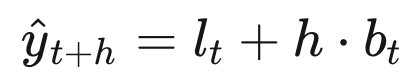

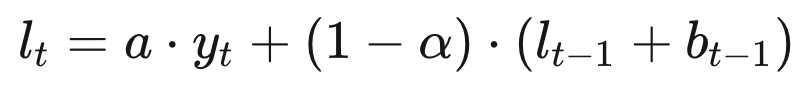

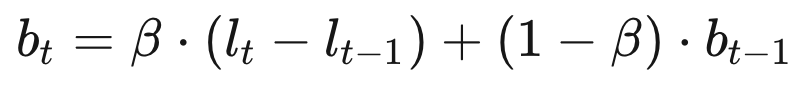

In the above equations, α and β are constants which can be configured. The values lt and bt represent the level and trend values repsectively. The trend value is the slope of the linear forecast function and the level value is the y-intercept of the linear forecast function. The slope and y-intercept values are continuously updated using the second and third update equations. Finally, the slope and y-intercept are used to calculate the forecast yt+h (in equation 1), which is h time steps ahead of the current time step.

In [ ]:
holt=Holt(np.asarray(model_train["confirmed"])).fit(smoothing_level=0.4, smoothing_slope=0.4,optimized=False)    

In [ ]:
y_pred["Holt"]=holt.forecast(len(valid))
model_scores.append(np.sqrt(mean_squared_error(y_pred["confirmed"],y_pred["Holt"])))
print("Root Mean Square Error Holt's Linear Model: ",np.sqrt(mean_squared_error(y_pred["confirmed"],y_pred["Holt"])))
mape = np.mean(np.abs((y_pred["confirmed"].values - y_pred["Holt"])/y_pred["confirmed"].values))*100
print("MAPE: ",mape)

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Holt"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Holt's Linear Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

**Holt's Linear Model performs the best among all the models that we have yet tried.**

In [ ]:
holt_new_date=[]
holt_new_prediction=[]
for i in range(1,18):
    holt_new_date.append(datetime.now() + timedelta(days=i))
    holt_new_prediction.append(holt.forecast((len(valid)+i))[-1])

model_predictions["Holt's Linear Model Prediction"]=holt_new_prediction
model_predictions.head()

**Holts's Winter Model**

Holt-Winters is a model of time series behavior. Forecasting always requires a model, and Holt-Winters is a way to model three aspects of the time series: a typical value (average), a slope (trend) over time, and a cyclical repeating pattern (seasonality). Holt-Winters uses exponential smoothing to encode lots of values from the past and use them to predict “typical” values for the present and future.

Exponential smoothing assigns exponentially decreasing weights and values against historical data to decrease the value of the weight for the older data. In other words, more recent historical data is assigned more weight in forecasting than the older results.



In [ ]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [ ]:
es=ExponentialSmoothing(np.asarray(model_train['confirmed']),seasonal_periods=14,trend='add', seasonal='mul').fit()

In [ ]:
y_pred["Holt's Winter Model"]=es.forecast(len(valid))
model_scores.append(np.sqrt(mean_squared_error(y_pred["confirmed"],y_pred["Holt's Winter Model"])))
print("Root Mean Square Error for Holt's Winter Model: ",np.sqrt(mean_squared_error(y_pred["confirmed"],y_pred["Holt's Winter Model"])))
mape = np.mean(np.abs((y_pred["confirmed"].values - y_pred["Holt's Winter Model"])/y_pred["confirmed"].values))*100
print("MAPE: ",mape)

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Holt\'s Winter Model"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Holt's Winter Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

**Holts Winter Model is giving the lowest error and we can safely assusme that this is the best model to be used for predicting no of COVID-19 cases**

**Predicting cases for the next few days**

In [ ]:
holt_winter_new_prediction=[]
for i in range(1,18):
    holt_winter_new_prediction.append(es.forecast((len(valid)+i))[-1])
model_predictions["Holt's Winter Model Prediction"]=holt_winter_new_prediction
model_predictions.head()